<h2> Skin Cancer Kaggle challenge </h2>
<p>https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000</p>
<p> Dermatoscopic images from different populations, acquired and stored by different modalities. The final dataset consists of 10015 dermatoscopic images which can serve as a training set for academic machine learning purposes. Cases include a representative collection of all important diagnostic categories in the realm of pigmented lesions: Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec), basal cell carcinoma (bcc), benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl), dermatofibroma (df), melanoma (mel), melanocytic nevi (nv) and vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc). </p>

In [41]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd

In [22]:
!ls archive

HAM10000_images_part_1 hmnist_28_28_L.csv     hmnist_8_8_RGB.csv
HAM10000_images_part_2 hmnist_28_28_RGB.csv
HAM10000_metadata.csv  hmnist_8_8_L.csv


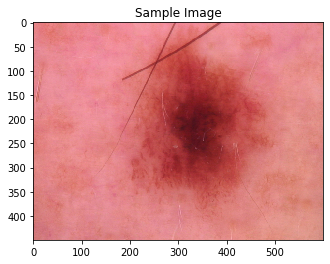

In [23]:
# https://stackoverflow.com/questions/39316447/opencv-giving-wrong-color-to-colored-images-on-loading

img = cv2.imread('archive/HAM10000_images_part_1/ISIC_0024306.jpg')
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)
plt.title('Sample Image')
plt.show()

In [31]:
df = pd.read_csv("archive/HAM10000_metadata.csv")

In [37]:
df.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization'], dtype='object')

<p>More than 50% of lesions are confirmed through histopathology (histo), the ground truth for the rest of the cases is either follow-up examination (followup), expert consensus (consensus), or confirmation by in-vivo confocal microscopy (confocal). The dataset includes lesions with multiple images, which can be tracked by the lesionid-column within the HAM10000_metadata file.</p>

In [38]:
df.head(1)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp


<p>Cases include a representative collection of all important diagnostic categories in the realm of pigmented lesions: Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec), basal cell carcinoma (bcc), benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl), dermatofibroma (df), melanoma (mel), melanocytic nevi (nv) and vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc).</p>

In [36]:
# labels
set(df.dx)

{'akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'}

<p>A simple CNN and linear architecture will be used. There are nuances of dx_type, localization, and sex to later consider. For now the dataset will be split with even distribution with respect to the primary label of dx</p>

<p>A function will be needed to map the images with the corresponding row of the metadata file</p>

<h3> Add images to df </h3>
<p>Add images to df and pickle to file df_with_images.pkl. <b><i>Skip</i></b> if this file has already been created.</p>

In [40]:
def map_meta_csv_and_img(df, images_dir="archive"):
    """
    Given the HAM10000_metadata.csv, maps the corresponding image array to the row
    """
    images = []
    for i in df['image_id']:
        image_path = os.path.join(f"{images_dir}/HAM10000_images_part_1", f"{i}.jpg")
        if os.path.isfile(image_path):
            img = cv2.imread(image_path)
            RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(RGB_img)
        else:
            image_path = os.path.join(f"{images_dir}/HAM10000_images_part_2", f"{i}.jpg")
            if os.path.isfile(image_path):
                img = cv2.imread(image_path)
                RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(RGB_img)
            else:
                print("image not found")
                images.append([])
    df["images"] = images
    return df

In [45]:
%%time

df = map_meta_csv_and_img(df)

'ISIC_0027419.jpg'

In [66]:
df.head(1)

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_array
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,"[[[188, 147, 191], [186, 148, 189], [187, 150,..."


In [65]:
%%time

df.to_pickle("df_with_images.pkl")

<h3> Load df </h3>
<p> load df df_with_images.pkl if the df has not been prepared </p>

In [ ]:
df = pd.read_pickle("df_with_images.pkl")

<h2>Display images with labels</h2>

In [76]:
labels = list(set(df['dx']))

In [72]:
from collections import Counter

In [75]:
Counter(df['dx'])

Counter({'bkl': 1099,
         'nv': 6705,
         'df': 115,
         'mel': 1113,
         'vasc': 142,
         'bcc': 514,
         'akiec': 327})

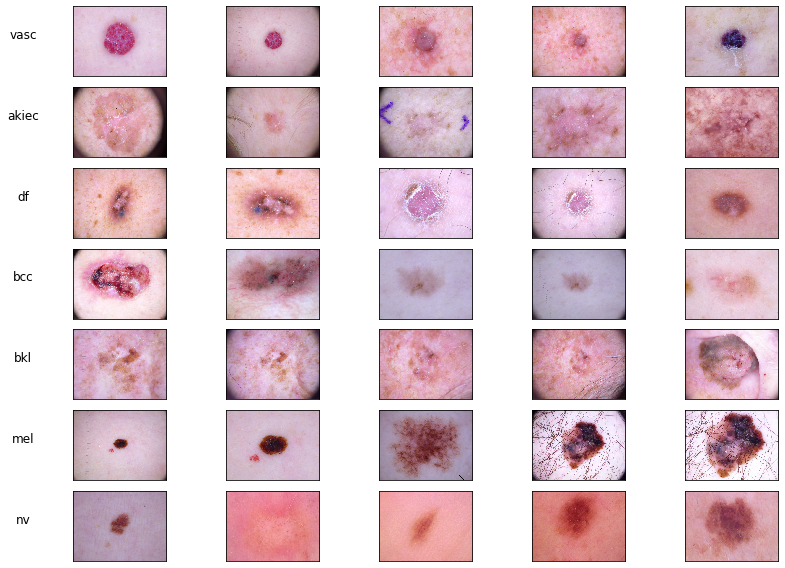

In [198]:
# https://stackoverflow.com/questions/41793931/plotting-images-side-by-side-using-matplotlib
rows = ['{}'.format(row) for row in labels]

fig, axes = plt.subplots(nrows=len(labels), ncols=5, figsize=(12, 8))

for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=0, size='large',labelpad=50)

for idx, label in enumerate(labels):
    for j in range(0, 5):
        image_array = df[df['dx']==label].iloc[j]['image_array']
        axes[idx,j].imshow(image_array)
        axes[idx, j].tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
            left=False,
            labelleft=False,
            labelright=False,
            labeltop=False,
    labelbottom=False) # labels along the bottom edge are off

        #plt.axis('off')
fig.tight_layout()
plt.show()

<h2>Prepare Training and Testing set</h2>
<p>Split dataset 70% training samples and 30% test samples</p>

<p>To test if the nn architecture converges test with 100 samples. Remember to normalize image array. One hot encode labels</p>

In [199]:
from sklearn.model_selection import train_test_split
import numpy as np

In [260]:
images = df['image_array']
images = np.array(images).reshape(len(images), 1)

labels = np.array(df['dx'])

In [261]:
X_train, X_test, y_train, y_test = train_test_split(images, np.array(labels), test_size=0.30, random_state=42, stratify=list(np.array(labels)))

In [265]:
np.save("train", X_train)
np.save("test", X_test)
np.save("train-labels", y_train)
np.save("test-labels", y_test)